<a href="https://colab.research.google.com/github/smf-9000/kaggle/blob/main/%5B002%5D_tps_jul_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://www.kaggle.com/ivankontic/002-tps-jul-2021" target="_parent"><img alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
%config Completer.use_jedi = False

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imread
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from statsmodels.nonparametric.smoothers_lowess import lowess


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-jul-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-jul-2021/train.csv
/kaggle/input/tabular-playground-series-jul-2021/test.csv


In [ ]:
submission_ex = pd.read_csv('/kaggle/input/tabular-playground-series-jul-2021/sample_submission.csv')
train_df = pd.read_csv('/kaggle/input/tabular-playground-series-jul-2021/train.csv')
test_df = pd.read_csv('/kaggle/input/tabular-playground-series-jul-2021/test.csv')

targets_df = train_df[["target_carbon_monoxide","target_benzene","target_nitrogen_oxides"]].copy()
train_df.drop(["target_carbon_monoxide","target_benzene","target_nitrogen_oxides"], axis=1, inplace=True)  

In [ ]:
def root_mean_squared_log_error(y_true, y_pred):
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    return K.sqrt(msle(y_true, y_pred)) 

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7111 entries, 0 to 7110
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date_time          7111 non-null   object 
 1   deg_C              7111 non-null   float64
 2   relative_humidity  7111 non-null   float64
 3   absolute_humidity  7111 non-null   float64
 4   sensor_1           7111 non-null   float64
 5   sensor_2           7111 non-null   float64
 6   sensor_3           7111 non-null   float64
 7   sensor_4           7111 non-null   float64
 8   sensor_5           7111 non-null   float64
dtypes: float64(8), object(1)
memory usage: 500.1+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247 entries, 0 to 2246
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date_time          2247 non-null   object 
 1   deg_C              2247 non-null   float64
 2   relative_humidity  2247 non-null   float64
 3   absolute_humidity  2247 non-null   float64
 4   sensor_1           2247 non-null   float64
 5   sensor_2           2247 non-null   float64
 6   sensor_3           2247 non-null   float64
 7   sensor_4           2247 non-null   float64
 8   sensor_5           2247 non-null   float64
dtypes: float64(8), object(1)
memory usage: 158.1+ KB


In [ ]:
train_df.isna().sum()

date_time            0
deg_C                0
relative_humidity    0
absolute_humidity    0
sensor_1             0
sensor_2             0
sensor_3             0
sensor_4             0
sensor_5             0
dtype: int64

In [ ]:
test_df.isna().sum()

date_time            0
deg_C                0
relative_humidity    0
absolute_humidity    0
sensor_1             0
sensor_2             0
sensor_3             0
sensor_4             0
sensor_5             0
dtype: int64

### train dataset

In [ ]:
# ################################################################
# for c in train_df.columns:
#     if c != 'date_time':
#         fig = plt.figure(figsize = (15, 5))
#         g = train_df[c].plot()
#         g.legend([c])

In [ ]:
# ################################################################
# fig = plt.figure(figsize = (30,30))
# ax = fig.gca()
# hist = train_df[train_df.columns.values].hist(bins=150, ax = ax)

### test dataset

In [ ]:
# ################################################################
# for c in test_df.columns:
#     if c != 'date_time':
#         fig = plt.figure(figsize = (15, 5))
#         g = test_df[c].plot()
#         g.legend([c])

In [ ]:
# ################################################################
# fig = plt.figure(figsize = (30,30))
# ax = fig.gca()
# hist = test_df[test_df.columns.values].hist(bins=150, ax = ax)

### feature correlation

In [ ]:
# ################################################################
# corr = train_df.corr()
# fig = plt.figure(figsize = (15,15))
# sns.heatmap(corr, vmax = .8, square = True, annot=True)
# plt.show()

### new features

In [ ]:
# -------------------------------------------------
for df in [train_df, test_df]:
    df['deg_K'] = (df['deg_C'] + 273.15)
    df['deg_x'] = (df['deg_K']**-1)
    df['s_3'] = (df['sensor_3']**-1)
#     del df['deg_C']
    del df['deg_K']
    
    df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')

#     doy = df['date_time'].dt.dayofyear.values
#     df['day_of_y_sin'] = np.sin(doy * (2. * np.pi / 365))
#     df['day_of_y_cos'] = np.cos(doy * (2. * np.pi / 365))
#     hh = df['date_time'].dt.hour.values
#     df['hh_sin'] = np.sin(hh * (2. * np.pi / 24))
#     df['hh_cos'] = np.cos(hh * (2. * np.pi / 24))
    
    df['time'] = df['date_time'].astype(np.int64)//10**9
    df['hh'] = df['date_time'].dt.hour.values
    df['day_of_w'] = df['date_time'].dt.dayofweek.values
    df['weekend'] = df['day_of_w'].apply(lambda x: 1 if (x>4)  else 0)
    df['saturday'] = df['day_of_w'].apply(lambda x: 1 if (x == 5)  else 0)
    df['sunday'] = df['day_of_w'].apply(lambda x: 1 if (x == 6)  else 0)
    df['month'] = df['date_time'].dt.month.values
    
    ww = df["date_time"].dt.isocalendar().week.values
    df['ww_sin'] = np.sin(ww * (2. * np.pi / 52))
    df['ww_cos'] = np.cos(ww * (2. * np.pi / 52))
    df["working_h"] =  df["hh"].isin(np.arange(8, 21, 1)).astype("int")

    df["SMC"] = (df["absolute_humidity"] * 100) / df['relative_humidity']

    df['hm_1'] = ((df['absolute_humidity'].values <= 0.25)).astype(int)

    lag_features = ['deg_C', 'relative_humidity', 'absolute_humidity', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']
    lags = [3, 6, 9, 12, 24]
    for feature in lag_features:
        for lag in lags:
            df[feature + '_lag_' + str(lag)] = df[feature] - df[feature].shift(periods=lag, fill_value=0)

# -------------------------------------------------

### GridSearch

In [ ]:
# lgbm = LGBMRegressor()
# _target = 'target_carbon_monoxide'
# X = np.array(train_df[list(test_df.columns.values)[1:]].values, dtype='float32')
# hm_indices = train_df[train_df['hm_1'] == 1].index.values
# X = np.delete(X, hm_indices, axis=0)
# y = np.squeeze(np.array(targets_df[[_target]].values, dtype='float32'))
# y = np.delete(y, hm_indices, axis=0)
# params = {
#     'num_leaves': [16, 21, 26, 31, 36],
#     'learning_rate': [0.02, 0.01, 0.005],
#     'max_depth': [2, 3, 4, 5, 6],
#     'n_estimators': [1000, 1500, 2000]
# }
# grid= GridSearchCV(estimator=lgbm, param_grid = params, cv = 3, n_jobs=-1, verbose=True)
# grid.fit(X, y)
# print('=====================================', 'target: ', _target)
# print(grid.best_estimator_)
# print('-------------------------------------')
# print(grid.best_score_)
# print('-------------------------------------')
# print(grid.best_params_)

In [ ]:
# lgbm = LGBMRegressor()
# _target = 'target_benzene'
# X = np.array(train_df[list(test_df.columns.values)[1:]].values, dtype='float32')
# y = np.squeeze(np.array(targets_df[[_target]].values, dtype='float32'))
# params = {
#     'num_leaves': [3, 5, 7, 9],
#     'learning_rate': [0.03, 0.01, 0.003],
#     'max_depth': [-1, 2, 3, 4],
#     'n_estimators': [1000, 1500, 2000]
# }
# grid= GridSearchCV(estimator=lgbm, param_grid = params, cv = 3, n_jobs=-1, verbose=True)
# grid.fit(X, y)
# print('=====================================', 'target: ', _target)
# print(grid.best_estimator_)
# print('-------------------------------------')
# print(grid.best_score_)
# print('-------------------------------------')
# print(grid.best_params_)

In [ ]:
# lgbm = LGBMRegressor(reg_sqrt=True)
# _target = 'target_nitrogen_oxides'
# X = np.array(train_df[list(test_df.columns.values)[1:]].values, dtype='float32')
# hm_indices = train_df[train_df['hm_1'] == 1].index.values
# X = np.delete(X, hm_indices, axis=0)
# y = np.squeeze(np.array(targets_df[[_target]].values, dtype='float32'))
# y = np.delete(y, hm_indices, axis=0)
# params = {
#     'num_leaves': [6, 11, 16, 21, 26, 31],
#     'learning_rate': [0.05, 0.03, 0.02, 0.01],
#     'max_depth': [-1, 5, 10],
#     'n_estimators': [300, 500, 700, 800, 1000, 1500]
# }
# grid= GridSearchCV(estimator=lgbm, param_grid = params, cv = 3, n_jobs=-1, verbose=True)
# grid.fit(X, y)
# print('=====================================', 'target: ', _target)
# print(grid.best_estimator_)
# print('-------------------------------------')
# print(grid.best_score_)
# print('-------------------------------------')
# print(grid.best_params_)

### LGBMRegressor

In [ ]:
lgbm_regs = {}

lgbm_regs['target_carbon_monoxide'] = LGBMRegressor(learning_rate=0.005, max_depth=6, n_estimators=2000, num_leaves=26)

lgbm_regs['target_benzene'] = LGBMRegressor(learning_rate=0.03, n_estimators=2000, num_leaves=3)

lgbm_regs['target_nitrogen_oxides'] = LGBMRegressor(learning_rate=0.02, max_depth=10, n_estimators=300, reg_sqrt=True)

xgbr = XGBRegressor(objective = 'reg:squarederror')

### postprocessing

In [ ]:
def postprocessing(pred, df):
    _hh = df['hh'].values
    _dow = df['day_of_w'].values
    _hm = df['hm_1'].values
    Mlr = {}
    Mrl = {}
    C = [0 for _ in range(len(pred))]
    D = [0 for _ in range(len(pred))]
    for i in range(len(pred)):
        j = len(pred) - 1 - i
        hl = _hh[i]
        dl = _dow[i]
        hml = _hm[i]
        hr = _hh[j]
        dr = _dow[j]
        hmr = _hm[j]
        curr_kl = str(hl) + '_' + str(dl)
        curr_kr = str(hr) + '_' + str(dr)
        if hml != 1:
            if curr_kl not in Mlr:
                Mlr[curr_kl] = []
            Mlr[curr_kl].append(pred[i])
        else:
            if curr_kl in Mlr:
                if len(Mlr[curr_kl]) > 1:
                    D[i] += sum(Mlr[curr_kl][-2:])
                    C[i] += 2
                    pass
                else:
                    D[i] += Mlr[curr_kl][0]
                    C[i] += 1
        if hmr != 1:
            if curr_kr not in Mrl:
                Mrl[curr_kr] = []
            Mrl[curr_kr].append(pred[j])
        else:
            if curr_kr in Mrl:
                if len(Mrl[curr_kr]) > 1:
                    D[j] += sum(Mrl[curr_kr][-2:])
                    C[j] += 2
                    pass
                else:
                    D[j] += Mrl[curr_kr][0]
                    C[j] += 1
    
#     print(C)
    for i in range(len(pred)):
        if C[i] != 0:
            pred[i] = D[i] / C[i]

### submission

In [ ]:
submit = True

submit:  target_benzene
submit:  target_carbon_monoxide
submit:  target_nitrogen_oxides


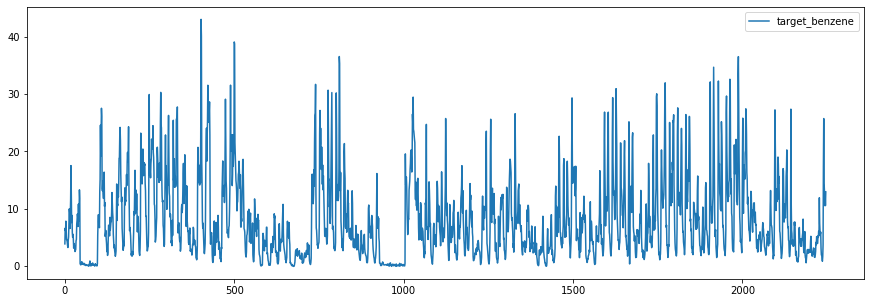

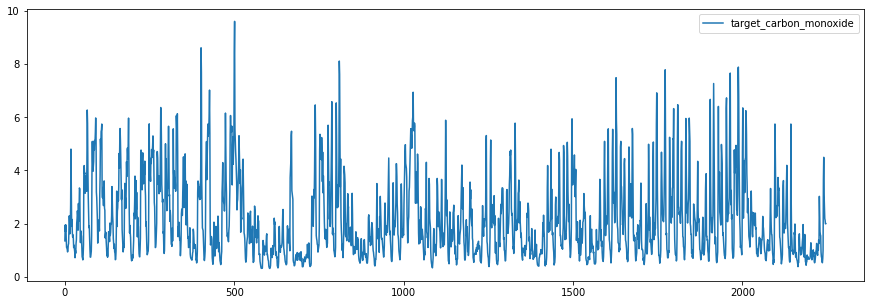

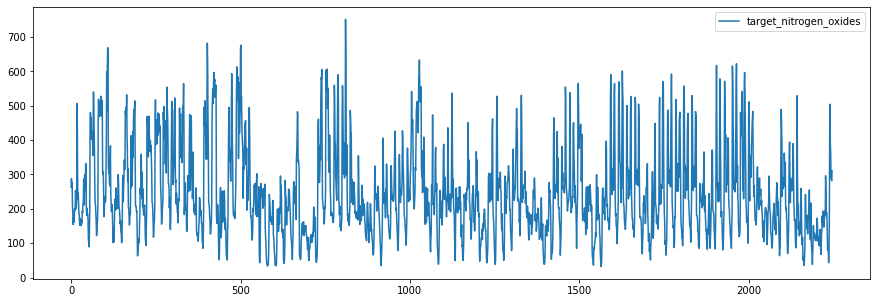

In [ ]:
submission = submission_ex.copy()

# p_x = None
# p_y = None
    
for _target in ['target_benzene', 'target_carbon_monoxide', 'target_nitrogen_oxides']:
    X = np.array(train_df[list(test_df.columns.values)[1:]].values, dtype='float32')
    hm_indices = train_df[train_df['hm_1'] == 1].index.values
    y = np.squeeze(np.array(targets_df[[_target]].values, dtype='float32'))
    X_test = np.array(test_df.iloc[:,1:].values, dtype='float32')
    
#     if p_x is not None:
#         X = np.c_[X, np.r_[p_x, p_y]]
    
    if not submit:
        split_train = 5500
        X, X_val = X[:split_train], X[split_train:]
        y, y_val = y[:split_train], y[split_train:]
        
        XX = X
        if _target != 'target_benzene':
            X = np.delete(X, [e for e in hm_indices if e < split_train], axis=0)
            y = np.delete(y, [e for e in hm_indices if e < split_train], axis=0)
        
        lgbm_regs[_target].fit(X, y)
        p1 = lgbm_regs[_target].predict(X_val)
        
        if _target != 'target_benzene':
            postprocessing(p1, train_df.iloc[split_train:,:])
        
#         p_y = p1
#         p_x = lgbm_regs[_target].predict(XX)
        
        print('target: ', _target)
        print('rmsle: ', root_mean_squared_log_error(y_val, p1))
        
        fig = plt.figure(figsize = (30, 10))
        g = targets_df.iloc[split_train:,:].reset_index()[_target].plot()
        tmp_col = pd.DataFrame(data=p1, columns=['tmp'])
        g = tmp_col['tmp'].plot(alpha = 0.7)
        g.legend([_target])
    else:
        print('submit: ', _target)
        
        if _target != 'target_benzene':
            X = np.delete(X, hm_indices, axis=0)
            y = np.delete(y, hm_indices, axis=0)
            
        lgbm_regs[_target].fit(X, y)
        p1 = lgbm_regs[_target].predict(X_test)
        
        if _target != 'target_benzene':
            postprocessing(p1, test_df)
            
        fig = plt.figure(figsize = (15, 5))
        tmp_col = pd.DataFrame(data=p1, columns=[_target])
        g = tmp_col[_target].plot()
        g.legend([_target])
            
        submission[_target] = p1


In [ ]:
submission.to_csv('submission.csv', index=False)

test = pd.read_csv('submission.csv')
test.tail()

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
2242,2011-04-04 10:00:00,2.619864,13.203853,362.899894
2243,2011-04-04 11:00:00,2.188348,10.521387,289.126739
2244,2011-04-04 12:00:00,2.129774,12.642797,286.919053
2245,2011-04-04 13:00:00,1.989757,10.531513,281.694510
2246,2011-04-04 14:00:00,1.998135,12.928319,310.577875


In [ ]:
test.head()

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,1.351548,3.835004,262.563508
1,2011-01-01 01:00:00,1.947507,6.578537,288.223414
2,2011-01-01 02:00:00,1.696889,6.085223,262.907443
3,2011-01-01 03:00:00,1.951980,7.811162,276.932260
4,2011-01-01 04:00:00,1.425240,5.897983,209.362640
